In [20]:
import sys, subprocess, importlib

def pipi(*args):
    print(">>", " ".join([sys.executable, "-m", "pip"]+list(args)))
    subprocess.check_call([sys.executable, "-m", "pip", *args])

pipi("install", "--upgrade", "pip", "setuptools", "wheel")
pipi("install", "kagglehub>=0.2.5", "pandas", "tqdm", "pillow")

for m in ["kagglehub", "pandas", "tqdm", "PIL"]:
    try:
        importlib.import_module(m if m!="PIL" else "PIL.Image")
        print(m, "OK")
    except Exception as e:
        print(m, "ERROR ->", e)

>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip install --upgrade pip setuptools wheel
Defaulting to user installation because normal site-packages is not writeable
>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip install kagglehub>=0.2.5 pandas tqdm pillow
Defaulting to user installation because normal site-packages is not writeable
kagglehub OK
pandas OK
tqdm OK
PIL OK


In [21]:
from pathlib import Path

# Kaggle Dataset
DATASET_ID = "adityajn105/flickr30k"

# Path
PROJECT = Path("/scratch/qin.yife/Generative_Project")

# Path Hierarchy
RAW_DIR = PROJECT / "data" / "raw" / "flickr30k_kaggle"
IMAGES_DIR = PROJECT / "data" / "processed" / "images"
PAIRS_CSV = PROJECT / "data" / "processed" / "pairs.csv"

for p in [RAW_DIR, IMAGES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("DATASET_ID:", DATASET_ID)
print("RAW_DIR   :", RAW_DIR)
print("IMAGES_DIR:", IMAGES_DIR)
print("PAIRS_CSV :", PAIRS_CSV)

DATASET_ID: adityajn105/flickr30k
RAW_DIR   : /scratch/qin.yife/Generative_Project/data/raw/flickr30k_kaggle
IMAGES_DIR: /scratch/qin.yife/Generative_Project/data/processed/images
PAIRS_CSV : /scratch/qin.yife/Generative_Project/data/processed/pairs.csv


In [22]:
import kagglehub, os
from pathlib import Path

DATASET_ID = "adityajn105/flickr30k" 
RAW_DIR    = Path("/scratch/qin.yife/Generative_Project/data/raw/flickr30k_kaggle")
RAW_DIR.mkdir(parents=True, exist_ok=True)

print("Downloading from Kaggle…  (first run may take a while)")
kaggle_path = kagglehub.dataset_download(DATASET_ID)
kaggle_path = Path(kaggle_path)
print("Kaggle cached path:", kaggle_path)

# Cache
def walk_dir(p: Path, max_files=50):
    files = []
    for root, dirs, fs in os.walk(p):
      for name in fs:
        files.append(Path(root)/name)
    files_sorted = sorted(files)
    print(f"Found {len(files_sorted)} files under: {p}")
    for f in files_sorted[:max_files]:
        try:
            sz = f.stat().st_size
        except Exception:
            sz = -1
        print(" -", f.relative_to(p), "|", f"{sz/1024/1024:.2f} MB" if sz>=0 else "?")
    if len(files_sorted) > max_files:
        print(f" ... ({len(files_sorted)-max_files} more)")

walk_dir(kaggle_path)

100%|██████████| 8.16G/8.16G [02:06<00:00, 69.0MB/s]

Extracting files...


Kaggle cached path: /home/qin.yife/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1
Found 63568 files under: /home/qin.yife/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1
 - Images/1000092795.jpg | 0.21 MB
 - Images/10002456.jpg | 0.11 MB
 - Images/1000268201.jpg | 0.19 MB
 - Images/1000344755.jpg | 0.15 MB
 - Images/1000366164.jpg | 0.10 MB
 - Images/1000523639.jpg | 0.14 MB
 - Images/1000919630.jpg | 0.11 MB
 - Images/10010052.jpg | 0.04 MB
 - Images/1001465944.jpg | 0.13 MB
 - Images/1001545525.jpg | 0.08 MB
 - Images/1001573224.jpg | 0.10 MB
 - Images/1001633352.jpg | 0.11 MB
 - Images/1001773457.jpg | 0.14 MB
 - Images/1001896054.jpg | 0.11 MB
 - Images/100197432.jpg | 0.11 MB
 - Images/100207720.jpg | 0.08 MB
 - Images/1002674143.jpg | 0.15 MB
 - Images/1003163366.jpg | 0.15 MB
 - Images/1003420127.jpg | 0.11 MB
 - Images/1003428081.jpg | 0.08 MB
 - Images/100444898.jpg | 0.08 MB
 - Images/1005216151.jpg | 0.14 MB
 - Images/100577935.jpg | 0.11 MB
 - Images/

In [23]:
from pathlib import Path
import os, re, json
import pandas as pd

KAGGLE_PATH = Path("/home/qin.yife/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1")
print("KAGGLE_PATH =", KAGGLE_PATH)

CANDIDATE_GLOBS = [
    "*captions*.txt",
    "*results*.csv",
    "*annotations*.txt",
    "*annotations*.csv",
    "*dataset*.json",
    "*.csv",
    "*.txt",
    "*.json",
]

candidates = []
for pat in CANDIDATE_GLOBS:
    candidates += list(KAGGLE_PATH.rglob(pat))

candidates = [p for p in candidates if "Images" not in str(p)]
candidates = [p for p in candidates if p.is_file()]

candidates = sorted(set(candidates), key=lambda p: (p.name.lower(), p.suffix.lower()))

print(f"Found {len(candidates)} possible annotation files.")
for i, p in enumerate(candidates[:15], 1):
    try:
        size_mb = p.stat().st_size / 1024 / 1024
    except Exception:
        size_mb = -1
    print(f"{i:>2}. {p.relative_to(KAGGLE_PATH)} | {size_mb:.2f} MB")

def safe_head_text(path: Path, n=5):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            lines = [next(f) for _ in range(n)]
        return "".join(lines)
    except Exception as e:
        return f"<cannot preview: {e}>"

print("\n--- Preview of first 3 candidates ---")
for p in candidates[:3]:
    print(f"\n[{p.name}]")
    if p.suffix.lower() == ".json":
        try:
            with open(p, "r", encoding="utf-8", errors="ignore") as f:
                sample = f.read(2000)
            print(sample[:500] + ("..." if len(sample)>500 else ""))
        except Exception as e:
            print("<json preview error>", e)
    else:
        print(safe_head_text(p, 8))

KAGGLE_PATH = /home/qin.yife/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1
Found 1 possible annotation files.
 1. captions.txt | 12.30 MB

--- Preview of first 3 candidates ---

[captions.txt]
image,caption
1000092795.jpg, Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg," Two young , White males are outside near many bushes ."
1000092795.jpg, Two men in green shirts are standing in a yard .
1000092795.jpg, A man in a blue shirt standing in a garden .
1000092795.jpg, Two friends enjoy time spent together .
10002456.jpg, Several men in hard hats are operating a giant pulley system .
10002456.jpg, Workers look down from up above on a piece of equipment .



In [24]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import shutil

KAGGLE_PATH = Path("/home/qin.yife/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1")
IMAGES_SRC  = KAGGLE_PATH / "Images"
CAP_FILE    = KAGGLE_PATH / "captions.txt"

PROJECT    = Path("/scratch/qin.yife/Generative_Project")
IMAGES_DIR = PROJECT / "data" / "processed" / "images"
PAIRS_CSV  = PROJECT / "data" / "processed" / "pairs.csv"

IMAGES_DIR.mkdir(parents=True, exist_ok=True)

# 1) Read captions.txt
df_cap = pd.read_csv(CAP_FILE)
assert set(df_cap.columns) >= {"image", "caption"}, f"Unexpected columns: {df_cap.columns}"

# 2) Match image with caption
df_first = df_cap.groupby("image", as_index=False).first()

# 3) 5000 pairs
df_first = df_first.sample(frac=1.0, random_state=42).reset_index(drop=True)
n_target = 5000
df_sub = df_first.iloc[:n_target].copy()

print(f"Unique images total: {len(df_first)} ; taking {len(df_sub)} pairs for export.")

# 4) Copying images
rows = []
for i, row in tqdm(df_sub.iterrows(), total=len(df_sub)):
    img_name = row["image"]
    caption  = str(row["caption"]).strip()
    src = IMAGES_SRC / img_name
    dst = IMAGES_DIR / img_name 

    if not src.exists():
        raise FileNotFoundError(f"Image not found: {src}")

    if not dst.exists():
        shutil.copy2(src, dst)

    rows.append({"image_path": str(dst), "caption": caption})

# 5) pairs.csv
out_df = pd.DataFrame(rows)
out_df.to_csv(PAIRS_CSV, index=False, encoding="utf-8")

print(f"\n[Done] Exported {len(out_df)} pairs.")
print("pairs.csv ->", PAIRS_CSV)
print("images    ->", IMAGES_DIR)
print("\nPreview:")
display(out_df.head(5))

Unique images total: 31783 ; taking 5000 pairs for export.


100%|██████████| 5000/5000 [00:44<00:00, 111.26it/s]



[Done] Exported 5000 pairs.
pairs.csv -> /scratch/qin.yife/Generative_Project/data/processed/pairs.csv
images    -> /scratch/qin.yife/Generative_Project/data/processed/images

Preview:


,image_path,caption
0,/scratch/qin.yife/Generative_Project/data/proc...,AN older woman appears to read from a children...
1,/scratch/qin.yife/Generative_Project/data/proc...,Numerous bicyclists wearing bicyclist apparel ...
2,/scratch/qin.yife/Generative_Project/data/proc...,In this picture we see multiple people crossin...
3,/scratch/qin.yife/Generative_Project/data/proc...,A baby on the floor laughing at an older anoth...
4,/scratch/qin.yife/Generative_Project/data/proc...,A man loads trees onto a cart on the side of a...


In [25]:
import pandas as pd
from pathlib import Path

PROJECT     = Path("/scratch/qin.yife/Generative_Project")
PAIRS_CSV   = PROJECT / "data" / "processed" / "pairs.csv"
CLEAN_CSV   = PROJECT / "data" / "processed" / "pairs.clean.csv"
MAX_LEN     = 128
ASCII_THRES = 0.8

df = pd.read_csv(PAIRS_CSV)
n0 = len(df)

# Data Preprocess
df["caption"] = df["caption"].fillna("").astype(str).str.strip()
df = df[df["caption"].str.len() > 0]
n_nonempty = len(df)

# drop duplicates
df = df.drop_duplicates(subset=["caption"])
n_dedup = len(df)

df["caption"] = df["caption"].str.slice(0, MAX_LEN)

# ASCII filtering
def ascii_ratio(s: str) -> float:
    if not s: 
        return 0.0
    return sum(ord(ch) < 128 for ch in s) / len(s)

df = df[df["caption"].apply(ascii_ratio) >= ASCII_THRES]
n_ascii = len(df)

# Rerange
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

df.to_csv(CLEAN_CSV, index=False, encoding="utf-8")

print(f"Raw pairs: {n0}")
print(f"After non-empty: {n_nonempty}  (dropped {n0 - n_nonempty})")
print(f"After de-dup   : {n_dedup}     (dropped {n_nonempty - n_dedup})")
print(f"After ASCII    : {n_ascii}     (dropped {n_dedup - n_ascii})")
print("Saved clean ->", CLEAN_CSV)

print("\nPreview (5 rows):")
display(df.head(5))

Raw pairs: 5000
After non-empty: 5000  (dropped 0)
After de-dup   : 5000     (dropped 0)
After ASCII    : 5000     (dropped 0)
Saved clean -> /scratch/qin.yife/Generative_Project/data/processed/pairs.clean.csv

Preview (5 rows):


,image_path,caption
0,/scratch/qin.yife/Generative_Project/data/proc...,A man and two young children are swimming in a...
1,/scratch/qin.yife/Generative_Project/data/proc...,A person in a green and white suit does tricks...
2,/scratch/qin.yife/Generative_Project/data/proc...,A toddler boy in a sailor suit and a little gi...
3,/scratch/qin.yife/Generative_Project/data/proc...,The man is wearing a green shirt and blue jean...
4,/scratch/qin.yife/Generative_Project/data/proc...,Three chefs in uniform are working in an assem...


In [2]:
import torch, transformers
print("torch:", torch.__version__, "| cuda available:", torch.cuda.is_available())
print("transformers:", transformers.__version__)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

torch: 2.9.0+cpu | cuda available: False
transformers: 4.45.0


In [3]:
import os, importlib
os.environ["HF_HOME"] = "/scratch/qin.yife/Generative_Project/.cache/huggingface"

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
print("HF_HOME =", os.environ["HF_HOME"])
print("HF_HUB_ENABLE_HF_TRANSFER (env) =", os.environ["HF_HUB_ENABLE_HF_TRANSFER"])

try:
    import huggingface_hub
    from huggingface_hub import constants as hf_constants
    hf_constants.HF_HUB_ENABLE_HF_TRANSFER = False
    import huggingface_hub.file_download as fd
    importlib.reload(fd)
    print("huggingface_hub fast-transfer disabled & file_download reloaded.")
except Exception as e:
    print("huggingface_hub not imported yet (that's fine).")

HF_HOME = /scratch/qin.yife/Generative_Project/.cache/huggingface
HF_HUB_ENABLE_HF_TRANSFER (env) = 0
huggingface_hub fast-transfer disabled & file_download reloaded.


In [4]:
import sys, subprocess

def pipi(*args):
    print(">>", " ".join([sys.executable, "-m", "pip"]+list(args)))
    try:
        subprocess.check_call([sys.executable, "-m", "pip", *args])
    except subprocess.CalledProcessError as e:
        print("(ignore if already uninstalled/installed)", e)

for pkg in ["open_clip_torch", "timm"]:
    pipi("uninstall", "-y", pkg)

# Install CPU  torch
cpu_idx = "https://download.pytorch.org/whl/cpu"
pipi("install", "--upgrade", "pip", "setuptools", "wheel")
pipi("install", "--index-url", cpu_idx, "torch", "torchvision", "torchaudio")

# Install transformers
pipi("install", "transformers==4.45.0", "huggingface-hub>=0.24", "safetensors")

import torch, transformers
print("torch:", torch.__version__, "| cuda available:", torch.cuda.is_available())
print("transformers:", transformers.__version__)

>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip uninstall -y open_clip_torch


>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip uninstall -y timm


>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip install --upgrade pip setuptools wheel
Defaulting to user installation because normal site-packages is not writeable
>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip install --index-url https://download.pytorch.org/whl/cpu torch torchvision torchaudio
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip install transformers==4.45.0 huggingface-hub>=0.24 safetensors
Defaulting to user installation because normal site-packages is not writeable
torch: 2.9.0+cpu | cuda available: False
transformers: 4.45.0


In [5]:
import torch, pandas as pd
from pathlib import Path
from transformers import CLIPTokenizerFast, CLIPModel
from tqdm import tqdm

PROJECT   = Path("/scratch/qin.yife/Generative_Project")
CSV_CLEAN = PROJECT/"data"/"processed"/"pairs.clean.csv"
OUT_EMB   = PROJECT/"embeddings"/"flickr30k_text_clip_vitb32.pt"

device = "cpu"
df = pd.read_csv(CSV_CLEAN)
texts = df["caption"].tolist()
print("pairs:", len(texts), "| device:", device)

model_id  = "openai/clip-vit-base-patch32"   
tokenizer = CLIPTokenizerFast.from_pretrained(model_id, cache_dir=os.environ["HF_HOME"])
model     = CLIPModel.from_pretrained(model_id, cache_dir=os.environ["HF_HOME"]).to(device).eval()

embeds = []
B = 64
with torch.no_grad():
    for i in tqdm(range(0, len(texts), B)):
        batch  = texts[i:i+B]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=77, return_tensors="pt").to(device)
        feats  = model.get_text_features(**inputs)          # [B, 512]
        feats  = feats / feats.norm(dim=-1, keepdim=True)   # L2 归一
        embeds.append(feats.cpu())

text_emb = torch.cat(embeds, dim=0)                         # [N, 512]
OUT_EMB.parent.mkdir(parents=True, exist_ok=True)
torch.save({"captions": texts, "embeddings": text_emb}, OUT_EMB)

print("Saved ->", OUT_EMB, "| shape:", tuple(text_emb.shape), "| dtype:", text_emb.dtype)

pairs: 5000 | device: cpu


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/home/qin.yife/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

100%|██████████| 79/79 [00:13<00:00,  5.93it/s]


Saved -> /scratch/qin.yife/Generative_Project/embeddings/flickr30k_text_clip_vitb32.pt | shape: (5000, 512) | dtype: torch.float32


In [6]:
import sys, subprocess, os

def pipi(*args):
    print(">>", " ".join([sys.executable, "-m", "pip"]+list(args)))
    subprocess.check_call([sys.executable, "-m", "pip", *args])


pipi("install", "diffusers==0.30.0", "accelerate==0.34.2", "transformers==4.45.0", "safetensors")

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

import diffusers, transformers, torch
print("diffusers:", diffusers.__version__)
print("transformers:", transformers.__version__)
print("torch:", torch.__version__, "| cuda available:", torch.cuda.is_available())

>> /shared/EL9/explorer/anaconda3/2024.06/bin/python -m pip install diffusers==0.30.0 accelerate==0.34.2 transformers==4.45.0 safetensors
Defaulting to user installation because normal site-packages is not writeable
diffusers: 0.30.0
transformers: 4.45.0
torch: 2.9.0+cpu | cuda available: False


In [7]:
import torch, os
from diffusers import StableDiffusionPipeline
from pathlib import Path

os.environ["HF_HOME"] = "/scratch/qin.yife/Generative_Project/.cache/huggingface"

PROJECT = Path("/scratch/qin.yife/Generative_Project")
outdir  = PROJECT / "outputs" / "samples"
outdir.mkdir(parents=True, exist_ok=True)

device   = "cuda" if (hasattr(torch, "cuda") and torch.cuda.is_available()) else "cpu"
model_id = "stabilityai/sd-turbo" 

print("Loading model:", model_id, "| device:", device)
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=(torch.float16 if device == "cuda" else torch.float32),
    cache_dir=os.environ["HF_HOME"],
).to(device)

prompts = [
    "a golden retriever playing frisbee in a park, sunny day",
    "a modern city skyline at sunset, highly detailed, cinematic lighting",
    "a ceramic bowl of ramen on a wooden table, shallow depth of field",
    "a watercolor painting of a lighthouse on a rocky coast",
    "a person riding a bicycle in the rain at night, reflections on wet street",
]

steps, g_scale, seed = 12, 7.5, 123
generator = torch.Generator(device=device).manual_seed(seed)

saved = []
for i, p in enumerate(prompts, 1):
    img = pipe(
        p,
        num_inference_steps=steps,
        guidance_scale=g_scale,
        generator=generator
    ).images[0]
    fn = outdir / f"sample_{i:02d}.png"
    img.save(fn)
    saved.append((str(fn), p))

print("Saved images:")
for fn, p in saved:
    print(" -", fn, "| prompt:", p)

Loading model: stabilityai/sd-turbo | device: cpu


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Saved images:
 - /scratch/qin.yife/Generative_Project/outputs/samples/sample_01.png | prompt: a golden retriever playing frisbee in a park, sunny day
 - /scratch/qin.yife/Generative_Project/outputs/samples/sample_02.png | prompt: a modern city skyline at sunset, highly detailed, cinematic lighting
 - /scratch/qin.yife/Generative_Project/outputs/samples/sample_03.png | prompt: a ceramic bowl of ramen on a wooden table, shallow depth of field
 - /scratch/qin.yife/Generative_Project/outputs/samples/sample_04.png | prompt: a watercolor painting of a lighthouse on a rocky coast
 - /scratch/qin.yife/Generative_Project/outputs/samples/sample_05.png | prompt: a person riding a bicycle in the rain at night, reflections on wet street


Preview: sample_01.png


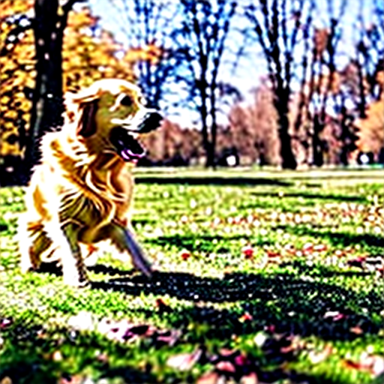

Preview: sample_02.png


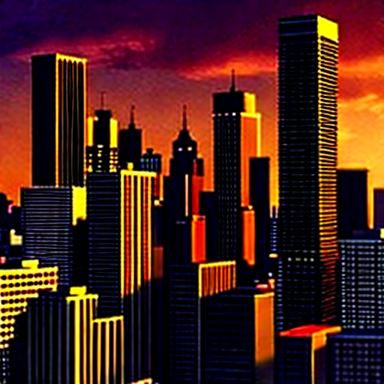

Preview: sample_03.png


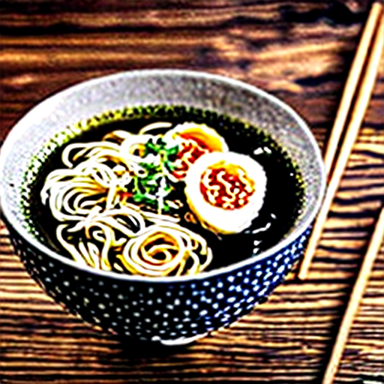

Preview: sample_04.png


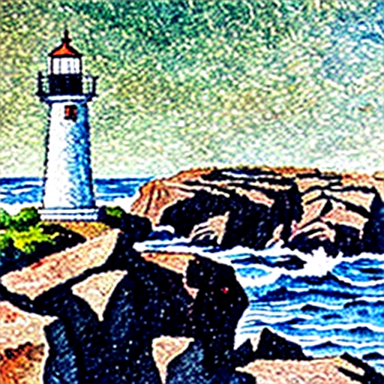

Preview: sample_05.png


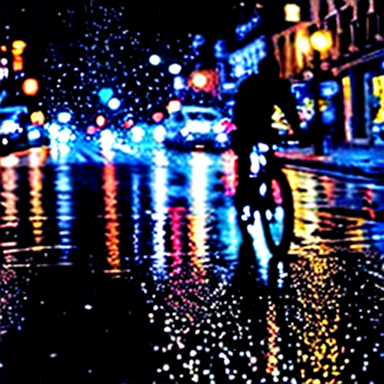

In [9]:
from PIL import Image
from IPython.display import display
from pathlib import Path

PROJECT = Path("/scratch/qin.yife/Generative_Project")
outdir  = PROJECT / "outputs" / "samples"

imgs = sorted(outdir.glob("sample_*.png"))[:5]
thumbs = []
for p in imgs:
    im = Image.open(p).copy()
    im.thumbnail((384, 384))
    print("Preview:", p.name)
    display(im)